A Quantum Covariance Matrix (QCM) is a quantum geenralization of a classical covariance matrix where statistical expectation values of random variables under a probability distribution are replaced by quantum expectation values of Hermitian operators under a wave function. (Clark, 2018)

$$ (C_T)_{a,b} := \langle \hat{h}_a \hat{h}_b \rangle - \langle \hat{h}_a \rangle \langle \hat{h}_b \rangle $$

Using Matrix Product State (MPS) representation of wavefunctions, we can easily use TeNPy to reproduce some certain QCM with local Hamiltonians of interests.
In TeNPy, there are many intuitive implementations of local Hamiltonians called 'terms', which are super helpful for this task.

## Override the Python mutliplication

In [ ]:
def mul(self, other):
    terms = []
    strength = []
    for termlist1 in self:
        for termlist2 in other:
            termlist = termlist1[0] + termlist2[0]
            terms.append(termlist)
            strength.append(termlist1[1] * termlist2[1])
    return TermList(terms, strength)
TermList.__mul__ = mul

## A class for QCM

In [26]:
class QCM:
    def __init__(self, psi, h_list):
        self.psi = psi.copy() # MPS
        self.h_list = h_list # the basis vector h_a, a list of TermList
        
        self.calc_average_ha() # the average, i.e. expectation value of each basis
        self.calc_average_hahb() # the cross terms
        self.calc_QCM()
        
    def calc_average_ha(self):
        """
            Calculate the expectation values of each basis Hamiltonian,
            by seeing each as a sum of local operators and then directly calculating
            the expectation value
        """
        self.average_ha = [self.psi.expectation_value_terms_sum(h)[0] for h in self.h_list]
    def calc_average_hahb(self):
        """
            The cross values...
        """
        n = len(self.h_list)
        self.ab_matrix = np.zeros((n, n), dtype='complex64')
        for i in range(n):
            for j in range(n):
                self.ab_matrix[i, j] = self.psi.expectation_value_terms_sum(self.h_list[i] * self.h_list[j])[0]
    def calc_QCM(self):
        n = len(self.h_list)
        mat = self.ab_matrix.copy()
        for i in range(n):
            for j in range(n):
                mat[i, j] -= self.average_ha[i]*self.average_ha[j]
        self.qcm = mat

# Tests on the class `TermList`

In [17]:
import tenpy
from tenpy.networks.terms import TermList

import numpy as np

In [12]:
tl = TermList([[('Cd', 0), ('C', 2)], [('Cd', 2), ('C', 0)], [('N', 1)]],
...              [0.5,                   0.5,                   1.3])

In [13]:
for t in tl:
    print(t)

([('Cd', 0), ('C', 2)], 0.5)
([('Cd', 2), ('C', 0)], 0.5)
([('N', 1)], 1.3)


Just as TeNPy's documentation has indicated, the class `TermList` defines a list of 'terms', each of which are composed of the local operator tensored together along with their prefactors.

In [14]:
tl.__len__ = print

In [15]:
def mul(self, other):
    terms = []
    strength = []
    for termlist1 in self:
        for termlist2 in other:
            termlist = termlist1[0] + termlist2[0]
            terms.append(termlist)
            strength.append(termlist1[1] * termlist2[1])
    return TermList(terms, strength)
TermList.__mul__ = mul

In [27]:
print(tl * tl)

0.25000 * Cd_0 C_2 Cd_0 C_2 +
0.25000 * Cd_0 C_2 Cd_2 C_0 +
0.65000 * Cd_0 C_2 N_1 +
0.25000 * Cd_2 C_0 Cd_0 C_2 +
0.25000 * Cd_2 C_0 Cd_2 C_0 +
0.65000 * Cd_2 C_0 N_1 +
0.65000 * N_1 Cd_0 C_2 +
0.65000 * N_1 Cd_2 C_0 +
1.69000 * N_1 N_1


# A benchmark with Rouchen's computation

This result should be equivalent to the result of https://github.com/ruochenma/Chiral-Spin-Liquid/blob/qcm/invert.py

In [6]:
Lx,Ly=2,4
L=2*Lx*Ly

Sp = 'Sp'
Sm = 'Sm'
Sz = 'Sz'

# 16 possible local couplings. NN and nNN hoping, SxSx+SySy vs. SzSz, two sublattices
op_list=[[Sp, Sm, 1, 0], [Sm, Sp, 1, 0], [Sp, Sm, 1, 1], [Sm, Sp, 1, 1],\
         [Sz, Sz, 1, 0], [Sz, Sz, 1, 0], [Sz, Sz, 1, 1], [Sz, Sz, 1, 1],\
         [Sp, Sm, 2, 0], [Sm, Sp, 2, 0], [Sp, Sm, 2, 1], [Sm, Sp, 2, 1],\
         [Sz, Sz, 2, 0], [Sz, Sz, 2, 0], [Sz, Sz, 2, 1], [Sz, Sz, 2, 1],\
         [Sp, Sm, 2*Ly-1, 0], [Sm, Sp, 2*Ly-1, 0], [Sp, Sm, 2*Ly-1, 1], [Sm, Sp, 2*Ly-1, 1],\
         [Sz, Sz, 2*Ly-1, 0], [Sz, Sz, 2*Ly-1, 0], [Sz, Sz, 2*Ly-1, 1], [Sz, Sz, 2*Ly-1, 1],\
         [Sp, Sm, 3, 0], [Sm, Sp, 3, 0], [Sp, Sm, 3, 1], [Sm, Sp, 3, 1],\
         [Sz, Sz, 3, 0], [Sz, Sz, 3, 0], [Sz, Sz, 3, 1], [Sz, Sz, 3, 1]]

Issue: we need to know the explicit expression of variables `Sp`, `Sm` and `Sz`.

In [43]:
h_list = []

for i in range(L):
    tl = []
    if op_list[2*i][3]==0:
        for m in range(L):
            if m%2==0:
                if m%(2*Ly) +op_list[2*i][2] < 2*Ly:
#                     exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2])])\
#                         +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  )])
                    tl += [
                        [(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2])], 
                        [(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  )]
                    ]
                else:
#                     exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly)])\
#                         +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  )])
                    tl += [
                        [(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly)],
                        [(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  )]
                    ]
                    
    else:
        if op_list[2*i][2]%2==0:
            for m in range(L):
                if m%2 !=0:
                    if m%(2*Ly) +op_list[2*i][2] < 2*Ly:

#                         exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2])])\
#                             +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  )])
                        tl += [
                            [(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2])],
                            [(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  )]
                        ]
                    else:
#                         exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly)])\
#                             +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  )])
                        tl += [
                            [(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly)],
                            [(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  )],
                        ]
                    
        else: 
            for m in range(L):
                if m%2 !=0:

                    if m%(2*Ly) +op_list[2*i][2] + 2*Ly-2 < 4*Ly:
                        tl += [
                            [(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2)],
                            [(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2  )],
                        ]
#                         exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2)])\
#                             +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2  )])
                    else:
#                         exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2  )])\
#                             +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2  )])
                        tl += [
                            [(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2  )],
                            [(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2  )],
                        ]
    h_list.append(TermList(terms=tl))

In [37]:
h_list

# Get the iMPS

In [38]:
from tenpy.algorithms.dmrg import TwoSiteDMRGEngine
import numpy as np
from tenpy.models.lattice import Lattice
import tenpy.linalg.np_conserved as npc
from tenpy.networks.site import SpinHalfFermionSite
from tenpy.networks.mps import MPS
from tenpy.algorithms.truncation import svd_theta
from tenpy.linalg.np_conserved import Array
from tenpy.models.model import CouplingModel
from tenpy.models.model import CouplingMPOModel 

dmrg_params = {
    'mixer': True,
    'trunc_params': {'chi_max': 1000,
                     'svd_min': 1.e-8},
    'max_E_err': 1.e-8,
    'max_S_err': 1.e-7,
    'N_sweeps_check': 2,
    'max_sweeps': 100,
    'verbose': 1,
    'chi_list': {0: 100, 10: 1000},
}

model_params = {
    'Lx': 2, 'Ly': 4, 'bc':'periodic',# Ly is set below
    'bc_MPS': 'infinite',
    'verbose': 1,
    'cons_N': 'N',
    'cons_Sz': 'Sz',
    't': 1,
    'td': 0.5j,
}



class twosites(Lattice):
    def __init__(self, Lx, Ly, site, **kwargs):
        NN = [(0, 1, np.array([0, 0])), (1, 0, np.array([1, 0])), (0, 0, np.array([0, 1]))]
        NNa = [(1, 1, np.array([0, 1]))]
        nNN = [(0, 1, np.array([0, 1])), (1, 0, np.array([0, 1])),(1, 0, np.array([1, -1])), (0, 1, np.array([-1, -1]))]
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors', NN)
        kwargs['pairs'].setdefault('next_nearest_neighbors', NNa)
        kwargs['pairs'].setdefault('next_next_nearest_neighbors', nNN)
        Lattice.__init__(self, [Lx, Ly], site, **kwargs)




class FermionicChiral(CouplingMPOModel):

    #default_lattice = doublesites
    #force_default_lattice = True

    def init_sites(self, model_params):
        cons_N = model_params.get('cons_N', 'N')
        cons_Sz = model_params.get('cons_Sz', 'Sz')
        site = SpinHalfFermionSite(cons_N=cons_N, cons_Sz=cons_Sz)
        return site


    def init_lattice(self, model_params):
        Lx = model_params.get('Lx',1)
        Ly = model_params.get('Ly',8)
        fs = self.init_sites(model_params)
        bc = model_params.get('bc','periodic')
        bc_MPS = model_params.get('bc_MPS','infinite')
       

        lat = twosites(Lx, Ly, [fs,fs],bc=bc, bc_MPS=bc_MPS)
        return lat

    def init_terms(self, model_params):
        
        t = model_params.get('t', 1.)
        td = model_params.get('td', 0.5j)
       

        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(t , u1, 'Cdu', u2, 'Cu', dx, plus_hc=True)
            self.add_coupling(t , u1, 'Cdd', u2, 'Cd', dx, plus_hc=True)
            
        for u1, u2, dx in self.lat.pairs['next_nearest_neighbors']:
            self.add_coupling(-t, u1, 'Cdu', u2, 'Cu', dx, plus_hc=True)
            self.add_coupling(-t, u1, 'Cdd', u2, 'Cd', dx, plus_hc=True)
            
        for u1, u2, dx in self.lat.pairs['next_next_nearest_neighbors']:
            self.add_coupling(td, u1, 'Cdu', u2, 'Cu', dx, plus_hc=True)
            self.add_coupling(td, u1, 'Cdd', u2, 'Cd', dx, plus_hc=True)

      
            
            
            
CSLnoGPO=FermionicChiral(model_params)

psi = MPS.from_lat_product_state(CSLnoGPO.lat, [[["up","down"]]],bc=CSLnoGPO.lat.bc_MPS)

            

            
            
eng = TwoSiteDMRGEngine(psi, CSLnoGPO, dmrg_params)



E, psi = eng.run()

Reading 'Lx'=2 for config FermionicChiral
Reading 'Ly'=4 for config FermionicChiral
Reading 'cons_N'='N' for config FermionicChiral
Reading 'cons_Sz'='Sz' for config FermionicChiral
Reading 'bc'='periodic' for config FermionicChiral
Reading 'bc_MPS'='infinite' for config FermionicChiral
Reading 't'=1 for config FermionicChiral
Reading 'td'=0.5j for config FermionicChiral
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'chi_list'={0: 100, 10: 1000} for config TwoSiteDMRGEngine
Setting chi_max = 100
Initial sweeps...
Updating environment
.
Reading 'N_sweeps_check'=2 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=100 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-08 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-07 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Updating environment
.
sweep 2, age = 144
Energy = -2.1638429980719343, S = nan, norm_err = 7.8e-04
Current memory usage 175.1 MB, time 

In [3]:
from tenpy.tools.hdf5_io import save, load

In [2]:
import tenpy
tenpy.version.full_version

'0.8.4'

In [5]:
psi = load('test.h5')

In [19]:
for h in h_list:
    print("h = ", h)
    have = psi.expectation_value_terms_sum(h)
    print(have)

h =  1.00000 * Sp_14 Sm_15 +
1.00000 * Sm_14 Sp_15
(-0.09715058069713155, <tenpy.networks.mpo.MPO object at 0x7fef1222be10>)
h =  1.00000 * Sp_15 Sm_22 +
1.00000 * Sm_15 Sp_22
(-0.09694814590507353, <tenpy.networks.mpo.MPO object at 0x7fef122337d0>)
h =  1.00000 * Sz_14 Sz_15 +
1.00000 * Sz_14 Sz_15
(-0.04857527752701241, <tenpy.networks.mpo.MPO object at 0x7fef1222b910>)
h =  1.00000 * Sz_15 Sz_22 +
1.00000 * Sz_15 Sz_22
(-0.048474096359016575, <tenpy.networks.mpo.MPO object at 0x7fef1222b7d0>)
h =  1.00000 * Sm_8 Sp_14 +
1.00000 * Sp_8 Sm_14
(-0.08719159999355833, <tenpy.networks.mpo.MPO object at 0x7fef1222bf50>)
h =  1.00000 * Sm_9 Sp_15 +
1.00000 * Sp_9 Sm_15
(-0.08719282850421937, <tenpy.networks.mpo.MPO object at 0x7fef1222b990>)
h =  1.00000 * Sz_8 Sz_14 +
1.00000 * Sz_8 Sz_14
(-0.043596025644630526, <tenpy.networks.mpo.MPO object at 0x7fef1222bd50>)
h =  1.00000 * Sz_9 Sz_15 +
1.00000 * Sz_9 Sz_15
(-0.04359647587786235, <tenpy.networks.mpo.MPO object at 0x7fef1222b610>)
h =  1

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2139: UserWarning: Tolerance 1.00e-10 not reached within 1 sites
  terms_sum = mpo_.expectation_value(self, max_range=ct.max_range())


(0.0, <tenpy.networks.mpo.MPO object at 0x7fef1222abd0>)
h =  1.00000 * Sz_9 Sz_14 +
1.00000 * Sz_9 Sz_14
(-0.015634026907654332, <tenpy.networks.mpo.MPO object at 0x7fef1222bb50>)
h =  1.00000 * Sz_15 Sz_16 +
1.00000 * Sz_15 Sz_16
(0.0, <tenpy.networks.mpo.MPO object at 0x7fef1227a050>)


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2139: UserWarning: Tolerance 1.00e-10 not reached within 1 sites
  terms_sum = mpo_.expectation_value(self, max_range=ct.max_range())


In [50]:
qcm = QCM(psi, h_list)

In [51]:
qcm.qcm

array([[ 1.50840211e+00+0.00000000e+00j,  9.47245024e-03+1.11943828e-05j,
         4.17009085e-01+0.00000000e+00j, -2.70536263e-02+1.10285200e-05j,
        -1.67985320e-01+1.06788957e-05j, -1.67988002e-01+8.98920098e-06j,
        -5.62740602e-02+1.05650779e-05j, -5.62753417e-02+8.91668606e-06j,
        -3.78893286e-01-1.83878601e-01j,  3.45557556e-02+1.20210871e-02j,
        -2.74818484e-02-1.83878437e-01j,  2.75476796e-05+1.20215230e-02j,
        -3.78924310e-01+1.83859020e-01j,  3.45179103e-02-1.19837392e-02j,
        -2.74807960e-02+1.83858946e-01j,  1.10393114e-06-1.19834105e-02j],
       [ 9.47245024e-03-1.11943828e-05j,  1.50706112e+00+0.00000000e+00j,
        -2.70535089e-02-1.13713850e-05j,  4.16059107e-01+0.00000000e+00j,
        -7.57101029e-02-3.34768124e-08j, -1.67956933e-01-1.80854113e-06j,
        -2.40632873e-02-2.98926693e-07j, -5.59937842e-02-2.13393832e-06j,
         3.44493724e-02+1.21736182e-02j, -3.78935874e-01-1.83878407e-01j,
        -4.49714862e-05+1.21739246e-0

In [52]:
CT

array([[ 1.50840294e+00-1.86371485e-17j,  9.47225094e-03+1.11777363e-05j,
         4.17009771e-01-1.58919246e-17j, -2.70537436e-02+1.10118208e-05j,
        -1.67986959e-01+1.06468224e-05j, -1.67988360e-01+8.88706290e-06j,
        -5.62750697e-02+1.05363570e-05j, -5.62756062e-02+8.81515734e-06j,
        -3.78894269e-01-1.83878943e-01j,  3.45557034e-02+1.20211365e-02j,
        -2.74818912e-02-1.83878779e-01j,  2.75149941e-05+1.20215723e-02j,
        -3.78925502e-01+1.83859512e-01j,  3.45178396e-02-1.19837848e-02j,
        -2.74809524e-02+1.83859438e-01j,  1.06543303e-06-1.19834570e-02j],
       [ 9.47225094e-03-1.11777363e-05j,  1.50706100e+00+5.40352923e-18j,
        -2.70536244e-02-1.13549368e-05j,  4.16059017e-01-4.43376170e-18j,
        -7.57103264e-02-3.01583931e-08j, -1.67956889e-01-1.80335815e-06j,
        -2.40634084e-02-2.95598738e-07j, -5.59937358e-02-2.12874625e-06j,
         3.44494432e-02+1.21736508e-02j, -3.78935874e-01-1.83878377e-01j,
        -4.49344516e-05+1.21739563e-0

In [57]:
np.allclose(CT - qcm.qcm,0, atol=1e-5)

True

# RC's code

In [ ]:
# C is used to construct the first part of the quantum coviance matrix
C = np.zeros((16, 16), dtype='complex64')


# Calculate the quantum covariance matrix. We assume lattice translation and Sz spin rotation symmetry.
def hsq(i,j):
    exp=0
    if op_list[2*i][3]==0:
        if op_list[2*j][3]==0:
            for m in range(L):
                for n in range(L):
                    if m%2==0 and n%2==0:
                        if m%(2*Ly) +op_list[2*i][2] < 2*Ly:
                            if n%(2*Ly) +op_list[2*j][2] < 2*Ly:
                                exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]   )])\
                                    +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]  )])\
                                    +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]  )])\
                                    +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]   )])
                            else:
                                exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly   )])\
                                    +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly  )])\
                                    +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly  )])\
                                    +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly   )])
                        else:
                            if n%(2*Ly) +op_list[2*j][2] < 2*Ly:
                                exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]   )])\
                                    +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]  )])\
                                    +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]  )])\
                                    +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]   )])
                            else:
                                exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly   )])\
                                    +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly  )])\
                                    +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly  )])\
                                    +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly   )])

                            
    if op_list[2*i][3]==0:
        if op_list[2*j][3]==1:
            for m in range(L):
                for n in range(L):
                    if m%2==0 and n%2==1:
                        if m%(2*Ly) +op_list[2*i][2] < 2*Ly:
                            if op_list[2*j][2]%2==0:
                                if n%(2*Ly) +op_list[2*j][2] < 2*Ly:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]   )])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]   )])
                                else:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly   )])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly   )])
                            else:
                                if n%(2*Ly) +op_list[2*j][2] + 2*Ly-2 < 4*Ly:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]+2*Ly-2   )])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]+2*Ly-2  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]+2*Ly-2  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]+2*Ly-2   )])
                                else:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2   )])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2   )])

                        else:
                            if op_list[2*j][2]%2==0:
                                if n%(2*Ly) +op_list[2*j][2] < 2*Ly:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]   )])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]   )])
                                else:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly   )])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly   )])
                            else:
                                if n%(2*Ly) +op_list[2*j][2] + 2*Ly-2 < 4*Ly:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]+2*Ly-2   )])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]+2*Ly-2  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]+2*Ly-2  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]+2*Ly-2   )])
                                else:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2   )])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2   )])

                                
                                
    
    if op_list[2*i][3]==1:
        if op_list[2*j][3]==0:
            for m in range(L):
                for n in range(L):
                    if m%2==1 and n%2==0:
                        if op_list[2*i][2]%2==0:
                            if m%(2*Ly) +op_list[2*i][2] < 2*Ly:
                                if n%(2*Ly) +op_list[2*j][2] < 2*Ly:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]   )])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]   )])
                                else:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly   )])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly   )])
                            else:
                                if n%(2*Ly) +op_list[2*j][2] < 2*Ly:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]   )])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]   )])
                                else:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly   )])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly   )])

                        else:
                            if m%(2*Ly) +op_list[2*i][2] + 2*Ly-2 < 4*Ly:
                                if n%(2*Ly) +op_list[2*j][2] < 2*Ly:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2])])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2] )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2] )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]   )])
                                else:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]-2*Ly)])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]-2*Ly )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]-2*Ly )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]-2*Ly   )])

                            else:
                                if n%(2*Ly) +op_list[2*j][2] < 2*Ly:
                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]   )])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]   )])
                                else:

                                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly   )])\
                                        +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly  )])\
                                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly   )])




                                
    if op_list[2*i][3]==1:
        if op_list[2*j][3]==1:
            for m in range(L):
                for n in range(L):
                    if m%2==1 and n%2==1:
                        if op_list[2*i][2]%2==0:
                            if op_list[2*j][2]%2==0:
                                if m%(2*Ly) +op_list[2*i][2] < 2*Ly:

                                    if n%(2*Ly) +op_list[2*j][2] < 2*Ly:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]   )])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]   )])
                                    else:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly   )])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly   )])
                                else:
                                    if n%(2*Ly) +op_list[2*j][2] < 2*Ly:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]   )])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]   )])
                                    else:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly   )])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly   )])

                            else:
                                if m%(2*Ly) +op_list[2*i][2] < 2*Ly:
                                    if n%(2*Ly) +op_list[2*j][2] + 2*Ly-2 < 4*Ly:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]+2*Ly-2   )])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]+2*Ly-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]+2*Ly-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]+2*Ly-2   )])
                                    else:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2   )])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2   )])

                                else:
                                    if n%(2*Ly) +op_list[2*j][2] + 2*Ly-2 < 4*Ly:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]+2*Ly-2   )])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]+2*Ly-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]+2*Ly-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]+2*Ly-2   )])
                                    else:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2   )])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2   )])




                        else:
                            if op_list[2*j][2]%2==0:
                                if m%(2*Ly) +op_list[2*i][2] + 2*Ly-2 < 4*Ly:
                                    if n%(2*Ly) +op_list[2*j][2] < 2*Ly:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2])])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2] )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2] )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]   )])
                                    else:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]-2*Ly)])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]-2*Ly )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]-2*Ly )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]-2*Ly   )])

                                else:
                                    if n%(2*Ly) +op_list[2*j][2] < 2*Ly:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]   )])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]   )])
                                    else:

                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly   )])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2*Ly  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2*Ly   )])

                            else:
                                if m%(2*Ly) +op_list[2*i][2] + 2*Ly-2 < 4*Ly:
                                    if n%(2*Ly) +op_list[2*j][2] + 2*Ly-2 < 4*Ly:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]+2*Ly-2   )])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]+2*Ly-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]+2*Ly-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]+2*Ly-2   )])
                                    else:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2   )])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2   )])


                                else:
                                    if n%(2*Ly) +op_list[2*j][2] + 2*Ly-2 < 4*Ly:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]+2*Ly-2   )])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]+2*Ly-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2  ), (op_list[2*j][0] , n),(op_list[2*j][1],n+op_list[2*j][2]+2*Ly-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1],n+op_list[2*j+1][2]+2*Ly-2   )])
                                    else:
                                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2   )])\
                                            +psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2  ), (op_list[2*j][0] , n),(op_list[2*j][1], n+op_list[2*j][2]-2  )])\
                                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2   ), (op_list[2*j+1][0] , n),(op_list[2*j+1][1], n+op_list[2*j+1][2]-2   )])




    C[i,j]=exp




                                
                                
                                
                                
                                
                                
for i in range(16):
    for j in range(16):
        print(i,j)
        hsq(i,j)
        
        
print(C)

In [62]:
#quantum covariance matrix, part 2
ha=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
def halin(i):
    exp=0
    if op_list[2*i][3]==0:
        for m in range(L):
            if m%2==0:
                if m%(2*Ly) +op_list[2*i][2] < 2*Ly:
                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2])])\
                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  )])
                else:
                    exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly)])\
                        +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  )])
                    
                    
    else:
        if op_list[2*i][2]%2==0:
            for m in range(L):
                if m%2 !=0:
                    if m%(2*Ly) +op_list[2*i][2] < 2*Ly:

                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2])])\
                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  )])
                    else:
                        exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly)])\
                            +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  )])

                    
        mist[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2  )])

    ha[i]=exp
    
    
    
for i in range(16):
    halin(i)
    
    
C2= np.zeros((16, 16), dtype='complex64')
for i in range(L):
    for j in range(L):
        C2[i][j]=ha[i]*ha[j]
        
        
        
        
# The full quantum covariance matrix, eigenstates/eigenvalues

CT=C-C2

# Further Improvement: automatically generate the boundary conditions

First of all, add comments to indicate the specific effect of RC's code...

In [ ]:
Lx,Ly=2,4
L=2*Lx*Ly

Sp = 'Sp'
Sm = 'Sm'
Sz = 'Sz'

# 16 possible local couplings. NN and nNN hoping, SxSx+SySy vs. SzSz, two sublattices
op_list=[[Sp, Sm, 1, 0], [Sm, Sp, 1, 0], [Sp, Sm, 1, 1], [Sm, Sp, 1, 1],\
         [Sz, Sz, 1, 0], [Sz, Sz, 1, 0], [Sz, Sz, 1, 1], [Sz, Sz, 1, 1],\
         [Sp, Sm, 2, 0], [Sm, Sp, 2, 0], [Sp, Sm, 2, 1], [Sm, Sp, 2, 1],\
         [Sz, Sz, 2, 0], [Sz, Sz, 2, 0], [Sz, Sz, 2, 1], [Sz, Sz, 2, 1],\
         [Sp, Sm, 2*Ly-1, 0], [Sm, Sp, 2*Ly-1, 0], [Sp, Sm, 2*Ly-1, 1], [Sm, Sp, 2*Ly-1, 1],\
         [Sz, Sz, 2*Ly-1, 0], [Sz, Sz, 2*Ly-1, 0], [Sz, Sz, 2*Ly-1, 1], [Sz, Sz, 2*Ly-1, 1],\
         [Sp, Sm, 3, 0], [Sm, Sp, 3, 0], [Sp, Sm, 3, 1], [Sm, Sp, 3, 1],\
         [Sz, Sz, 3, 0], [Sz, Sz, 3, 0], [Sz, Sz, 3, 1], [Sz, Sz, 3, 1]]

"""
# YS comments: each (2i, 2i+1) tuple shares the same position pairs, and
                the difference is the swap between operators...

"""

In [83]:
#quantum covariance matrix, part 2
ha_new=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(L):
    exp=0
    print('i = ', i)
    op0 = op_list[2*i][0]
    op1 = op_list[2*i][1]
    print(f'op0 = {op0}')
    print(f'op1 = {op1}')
    for m in range(0, L, 2):
        site0 = m
        if op_list[2*i][3]==0: # first if-else: whether the pos tuple lies on the boundary
#         for m in range(L): # go through all m to apply the translational invariance
#             if m%2==0: # since it's calculating by site-pairs, here we only consider m=0, 2, 4, ...
            if m%(2*Ly) +op_list[2*i][2] < 2*Ly:
#                     site0 = m
                site1 = m+op_list[2*i][2]

                print('site0 = ', site0)
                print('site1 = ', site1)
                print('')
                exp+=psi.expectation_value_term([(op0 , site0),(op1, site1)])\
                    +psi.expectation_value_term([(op1 , site0),(op0, site1)])
            else:
#                     site0 = m
                site1 = m+op_list[2*i][2]-2*Ly
#                     print()
                print('site0 = ', site0)
                print('site1 = ', site1)
                print('')
                exp+=psi.expectation_value_term([(op0 , site0),(op1, site1)])\
                    +psi.expectation_value_term([(op1 , site0),(op0, site1)])

                    
#         else: # on the boundary
        elif op_list[2*i][2]%2==0:
            m+=1
            site0 = m
            print('site0 = ', site0)
            if m%(2*Ly) +op_list[2*i][2] < 2*Ly:
                site1 = m+op_list[2*i][2]
                print('site1 = ', site1)
                exp+=psi.expectation_value_term([(op0 , site0),(op1, site1)])\
                    +psi.expectation_value_term([(op1 , site0),(op0, site1)])
            else:
                site1 = m+op_list[2*i][2]-2*Ly
                print('site1 = ', site1)
                exp+=psi.expectation_value_term([(op0 , site0),(op1, site1)])\
                    +psi.expectation_value_term([(op1 , site0),(op0, site1)])

                    
        else: 
            m+=1
            site0 = m
            print('site0 = ', site0)
            if m%(2*Ly) +op_list[2*i][2] + 2*Ly-2 < 4*Ly:
                site1 = m+op_list[2*i][2]+2*Ly-2
                print('site1 = ', site1)
                exp+=psi.expectation_value_term([(op0, site0),(op1, site1)])\
                    +psi.expectation_value_term([(op1, site0),(op0, site1)])
            else:
                site1 = m+op_list[2*i][2]-2
                print('site1 = ', site1)
                exp+=psi.expectation_value_term([(op0, site0),(op1, site1)])\
                    +psi.expectation_value_term([(op1, site0),(op0, site1)])

    ha_new[i]=exp

i =  0
op0 = Sp
op1 = Sm
site0 =  0
site1 =  1

site0 =  2
site1 =  3

site0 =  4
site1 =  5

site0 =  6
site1 =  7

site0 =  8
site1 =  9

site0 =  10
site1 =  11

site0 =  12
site1 =  13

site0 =  14
site1 =  15

i =  1
op0 = Sp
op1 = Sm
site0 =  1
site1 =  8
site0 =  3
site1 =  10
site0 =  5
site1 =  12
site0 =  7
site1 =  14
site0 =  9
site1 =  16
site0 =  11
site1 =  18
site0 =  13
site1 =  20
site0 =  15
site1 =  22
i =  2
op0 = Sz
op1 = Sz
site0 =  0
site1 =  1

site0 =  2
site1 =  3

site0 =  4
site1 =  5

site0 =  6
site1 =  7

site0 =  8
site1 =  9

site0 =  10
site1 =  11

site0 =  12
site1 =  13

site0 =  14
site1 =  15

i =  3
op0 = Sz
op1 = Sz
site0 =  1
site1 =  8
site0 =  3
site1 =  10
site0 =  5
site1 =  12
site0 =  7
site1 =  14
site0 =  9
site1 =  16
site0 =  11
site1 =  18
site0 =  13
site1 =  20
site0 =  15
site1 =  22
i =  4
op0 = Sp
op1 = Sm
site0 =  0
site1 =  2

site0 =  2
site1 =  4

site0 =  4
site1 =  6

site0 =  6
site1 =  0

site0 =  8
site1 =  10

site0 =

In [82]:
np.allclose(ha, ha_new)

True

Interesting... It seems that `i=9, 11, 12, 14` are incorrect?...

# A system for self-defining translationally-invariant Hamiltonian basis

In [170]:
import numpy as np
from tenpy.models.lattice import Lattice
import tenpy.linalg.np_conserved as npc
from tenpy.networks.site import SpinHalfFermionSite

model_params = {
    'Lx': 2, 'Ly': 4, 'bc':'periodic',# Ly is set below
    'bc_MPS': 'infinite',
    'verbose': 1,
    'cons_N': 'N',
    'cons_Sz': 'Sz',
    't': 1,
    'td': 0.5j,
}



class twosites(Lattice):
    def __init__(self, Lx, Ly, site, **kwargs):
        
#         sites = _parse_sites(sites, 2)
        basis = np.array(([1., 0.], [0., 1.]))
        delta = np.array([1., 0.])
        pos = (-delta / 4., delta / 4.)
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
     
       
        NN = [(0, 1, np.array([0, 0])), (1, 0, np.array([1, 0])), (0, 0, np.array([0, 1]))]
        NNa = [(1, 1, np.array([0, 1]))]
        nNN = [(0, 1, np.array([0, 1])), (1, 0, np.array([0, 1])),(1, 0, np.array([1, -1])), (0, 1, np.array([-1, -1]))]
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors', NN)
        kwargs['pairs'].setdefault('next_nearest_neighbors', NNa)
        kwargs['pairs'].setdefault('next_next_nearest_neighbors', nNN)
        Lattice.__init__(self, [Lx, Ly], site, **kwargs)



In [171]:
fs = SpinHalfFermionSite()
lat = twosites(Lx = 2, Ly = 4, site=[fs, fs], bc='periodic', bc_MPS='infinite')

In [172]:
lat.pairs

{'nearest_neighbors': [(0, 1, array([0, 0])),
  (1, 0, array([1, 0])),
  (0, 0, array([0, 1]))],
 'next_nearest_neighbors': [(1, 1, array([0, 1]))],
 'next_next_nearest_neighbors': [(0, 1, array([0, 1])),
  (1, 0, array([0, 1])),
  (1, 0, array([ 1, -1])),
  (0, 1, array([-1, -1]))]}

In [173]:
import matplotlib.pyplot as plt

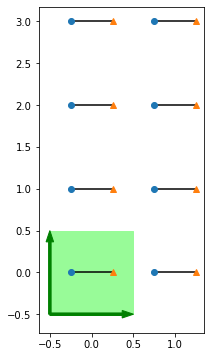

In [177]:
plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax, [lat.pairs['nearest_neighbors'][0]])

lat.plot_sites(ax)

lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
# ax.legend()

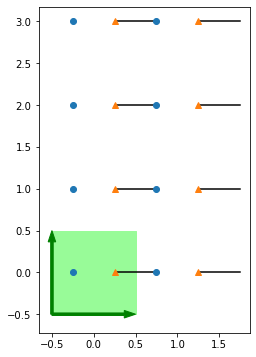

In [178]:
plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax, [lat.pairs['nearest_neighbors'][1]])

lat.plot_sites(ax)

lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
# ax.legend()

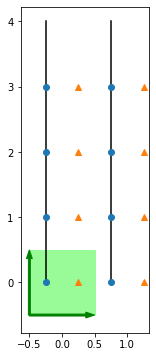

In [179]:
plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax, [lat.pairs['nearest_neighbors'][2]])

lat.plot_sites(ax)

lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
# ax.legend()

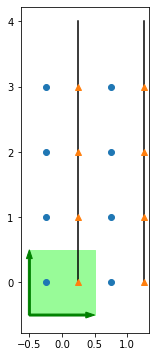

In [180]:
plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax, lat.pairs['next_nearest_neighbors'])

lat.plot_sites(ax)

lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
# ax.legend()

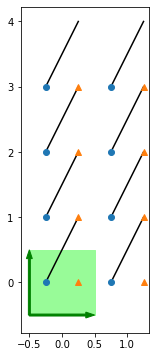

In [181]:
plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax, [lat.pairs['next_next_nearest_neighbors'][0]])

lat.plot_sites(ax)

lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
# ax.legend()

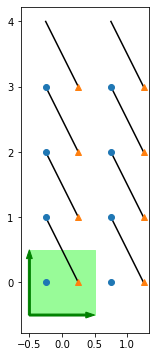

In [182]:
plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax, [lat.pairs['next_next_nearest_neighbors'][1]])

lat.plot_sites(ax)

lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
# ax.legend()

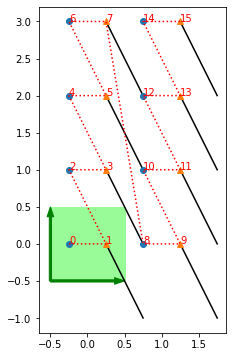

In [184]:
plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax, [lat.pairs['next_next_nearest_neighbors'][2]])

lat.plot_sites(ax)

lat.plot_order(ax, linestyle=':')
lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
# ax.legend()

In [ ]:
lat.plot_coupling()

In [117]:
coupling = lat.pairs['nearest_neighbors']
for u1, u2, dx in coupling:
    mps_i, mps_j, _, _ = lat.possible_couplings(u1, u2, dx)
    print(mps_i, mps_j)

[ 0  2  4  6  8 10 12 14] [ 1  3  5  7  9 11 13 15]
[ 1  3  5  7  9 11 13 15] [ 8 10 12 14 16 18 20 22]
[ 0  2  4  6  8 10 12 14] [ 2  4  6  0 10 12 14  8]


This means we can simply get the index pairs on mps...

In [130]:
def symmetric_op_term(op_list):
    assert len(op_list)==2 # just implemneted the 2-site coupling...
    op0, i0 = op_list[0]
    op1, i1 = op_list[1]
    return [[(op0, i0), (op1, i1)], [(op1, i0), (op0, i1)]]
op_list_test = [('Sp', 0), ('Sm', 1)]
symmetric_op_term(op_list_test)

[[('Sp', 0), ('Sm', 1)], [('Sm', 0), ('Sp', 1)]]

Good..

In [133]:
h_base = []
for pair in lat.pairs.values():
    for u1, u2, dx in pair:
        hh = []
        mps_i, mps_j, _, _ = lat.possible_couplings(u1, u2, dx)
        for i in range(len(mps_i)):
            site0 = mps_i[i]
            site1 = mps_j[i]
            op_list = [('Sp', site0), ('Sm', site1)]
            hh += symmetric_op_term(op_list)
        h_base.append(TermList(terms=hh))
"""
    Here by this loop we automatically apply the translation variance onto the coupling,
    one by one
"""
        
# for pair in lat.pairs.values():
#     for u1, u2, dx in pair:
        hh = []
        mps_i, mps_j, _, _ = lat.possible_couplings(u1, u2, dx)
        for i in range(len(mps_i)):
            site0 = mps_i[i]
            site1 = mps_j[i]
            op_list = [('Sz', site0), ('Sz', site1)]
            hh += symmetric_op_term(op_list)
        h_base.append(TermList(terms=hh))

In [134]:
for h in h_base:
    print(h)
    print('')

1.00000 * Sp_0 Sm_1 +
1.00000 * Sm_0 Sp_1 +
1.00000 * Sp_2 Sm_3 +
1.00000 * Sm_2 Sp_3 +
1.00000 * Sp_4 Sm_5 +
1.00000 * Sm_4 Sp_5 +
1.00000 * Sp_6 Sm_7 +
1.00000 * Sm_6 Sp_7 +
1.00000 * Sp_8 Sm_9 +
1.00000 * Sm_8 Sp_9 +
1.00000 * Sp_10 Sm_11 +
1.00000 * Sm_10 Sp_11 +
1.00000 * Sp_12 Sm_13 +
1.00000 * Sm_12 Sp_13 +
1.00000 * Sp_14 Sm_15 +
1.00000 * Sm_14 Sp_15

1.00000 * Sz_0 Sz_1 +
1.00000 * Sz_0 Sz_1 +
1.00000 * Sz_2 Sz_3 +
1.00000 * Sz_2 Sz_3 +
1.00000 * Sz_4 Sz_5 +
1.00000 * Sz_4 Sz_5 +
1.00000 * Sz_6 Sz_7 +
1.00000 * Sz_6 Sz_7 +
1.00000 * Sz_8 Sz_9 +
1.00000 * Sz_8 Sz_9 +
1.00000 * Sz_10 Sz_11 +
1.00000 * Sz_10 Sz_11 +
1.00000 * Sz_12 Sz_13 +
1.00000 * Sz_12 Sz_13 +
1.00000 * Sz_14 Sz_15 +
1.00000 * Sz_14 Sz_15

1.00000 * Sp_1 Sm_8 +
1.00000 * Sm_1 Sp_8 +
1.00000 * Sp_3 Sm_10 +
1.00000 * Sm_3 Sp_10 +
1.00000 * Sp_5 Sm_12 +
1.00000 * Sm_5 Sp_12 +
1.00000 * Sp_7 Sm_14 +
1.00000 * Sm_7 Sp_14 +
1.00000 * Sp_9 Sm_16 +
1.00000 * Sm_9 Sp_16 +
1.00000 * Sp_11 Sm_18 +
1.00000 * Sm_11 Sp_18 

In [129]:
for h in h_list:
    print(h)
    print('')

1.00000 * Sp_0 Sm_1 +
1.00000 * Sm_0 Sp_1 +
1.00000 * Sp_2 Sm_3 +
1.00000 * Sm_2 Sp_3 +
1.00000 * Sp_4 Sm_5 +
1.00000 * Sm_4 Sp_5 +
1.00000 * Sp_6 Sm_7 +
1.00000 * Sm_6 Sp_7 +
1.00000 * Sp_8 Sm_9 +
1.00000 * Sm_8 Sp_9 +
1.00000 * Sp_10 Sm_11 +
1.00000 * Sm_10 Sp_11 +
1.00000 * Sp_12 Sm_13 +
1.00000 * Sm_12 Sp_13 +
1.00000 * Sp_14 Sm_15 +
1.00000 * Sm_14 Sp_15

1.00000 * Sp_1 Sm_8 +
1.00000 * Sm_1 Sp_8 +
1.00000 * Sp_3 Sm_10 +
1.00000 * Sm_3 Sp_10 +
1.00000 * Sp_5 Sm_12 +
1.00000 * Sm_5 Sp_12 +
1.00000 * Sp_7 Sm_14 +
1.00000 * Sm_7 Sp_14 +
1.00000 * Sp_9 Sm_16 +
1.00000 * Sm_9 Sp_16 +
1.00000 * Sp_11 Sm_18 +
1.00000 * Sm_11 Sp_18 +
1.00000 * Sp_13 Sm_20 +
1.00000 * Sm_13 Sp_20 +
1.00000 * Sp_15 Sm_22 +
1.00000 * Sm_15 Sp_22

1.00000 * Sz_0 Sz_1 +
1.00000 * Sz_0 Sz_1 +
1.00000 * Sz_2 Sz_3 +
1.00000 * Sz_2 Sz_3 +
1.00000 * Sz_4 Sz_5 +
1.00000 * Sz_4 Sz_5 +
1.00000 * Sz_6 Sz_7 +
1.00000 * Sz_6 Sz_7 +
1.00000 * Sz_8 Sz_9 +
1.00000 * Sz_8 Sz_9 +
1.00000 * Sz_10 Sz_11 +
1.00000 * Sz_10 Sz_11 

In [140]:
def generate_h_base(
    lat, 
    op_pairs=[['Sp', 'Sm'], ['Sz', 'Sz']],
):
    """
        Automatically generate the Hamiltonian basis vectors,
        given a lattice and the operator pairs (a list of lists of operators)
    """
    
    h_base = []
    for op_list in op_pairs:
        op0 = op_list[0]
        op1 = op_list[1]
        for pair in lat.pairs.values():
            for u1, u2, dx in pair:
                hh = []
                mps_i, mps_j, _, _ = lat.possible_couplings(u1, u2, dx)
                for i in range(len(mps_i)):
                    site0 = mps_i[i]
                    site1 = mps_j[i]
                    op_list = [(op0, site0), (op1, site1)]
                    hh += symmetric_op_term(op_list)
                h_base.append(TermList(terms=hh))
    return h_base

h_base_new = generate_h_base(lat)

In [149]:
for h, j in zip(h_base, h_base_new):
    

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [185]:
for i, h in enumerate(h_base_new):
    print(i)
    print(h)
    print('')
    

0
1.00000 * Sp_0 Sm_1 +
1.00000 * Sm_0 Sp_1 +
1.00000 * Sp_2 Sm_3 +
1.00000 * Sm_2 Sp_3 +
1.00000 * Sp_4 Sm_5 +
1.00000 * Sm_4 Sp_5 +
1.00000 * Sp_6 Sm_7 +
1.00000 * Sm_6 Sp_7 +
1.00000 * Sp_8 Sm_9 +
1.00000 * Sm_8 Sp_9 +
1.00000 * Sp_10 Sm_11 +
1.00000 * Sm_10 Sp_11 +
1.00000 * Sp_12 Sm_13 +
1.00000 * Sm_12 Sp_13 +
1.00000 * Sp_14 Sm_15 +
1.00000 * Sm_14 Sp_15

1
1.00000 * Sp_1 Sm_8 +
1.00000 * Sm_1 Sp_8 +
1.00000 * Sp_3 Sm_10 +
1.00000 * Sm_3 Sp_10 +
1.00000 * Sp_5 Sm_12 +
1.00000 * Sm_5 Sp_12 +
1.00000 * Sp_7 Sm_14 +
1.00000 * Sm_7 Sp_14 +
1.00000 * Sp_9 Sm_16 +
1.00000 * Sm_9 Sp_16 +
1.00000 * Sp_11 Sm_18 +
1.00000 * Sm_11 Sp_18 +
1.00000 * Sp_13 Sm_20 +
1.00000 * Sm_13 Sp_20 +
1.00000 * Sp_15 Sm_22 +
1.00000 * Sm_15 Sp_22

2
1.00000 * Sp_0 Sm_2 +
1.00000 * Sm_0 Sp_2 +
1.00000 * Sp_2 Sm_4 +
1.00000 * Sm_2 Sp_4 +
1.00000 * Sp_4 Sm_6 +
1.00000 * Sm_4 Sp_6 +
1.00000 * Sm_0 Sp_6 +
1.00000 * Sp_0 Sm_6 +
1.00000 * Sp_8 Sm_10 +
1.00000 * Sm_8 Sp_10 +
1.00000 * Sp_10 Sm_12 +
1.00000 * Sm_1

In [150]:
qcm_new = QCM(psi, h_list=h_base_new)

In [152]:
np.linalg.eigh(qcm_new.qcm)

(array([0.09815211, 0.17365433, 0.30641377, 0.37300104, 0.42524707,
        0.57493967, 0.6293589 , 0.6728534 , 0.74482244, 0.845968  ,
        1.0855938 , 1.1186905 , 1.2608577 , 1.8512616 , 2.1783826 ,
        2.2233722 ], dtype=float32),
 array([[-2.39262059e-01+0.00000000e+00j, -1.49456516e-01+0.00000000e+00j,
         -1.39170349e-01+0.00000000e+00j,  7.95215964e-02+0.00000000e+00j,
          6.03414066e-02+0.00000000e+00j, -1.36381611e-02+0.00000000e+00j,
          4.65125948e-01+0.00000000e+00j,  1.59740642e-01+0.00000000e+00j,
          8.34455341e-02+0.00000000e+00j,  5.70519380e-02+0.00000000e+00j,
         -1.68451108e-02+0.00000000e+00j,  2.54153371e-01+0.00000000e+00j,
         -2.59513427e-02+0.00000000e+00j,  1.99419349e-01+0.00000000e+00j,
          3.50279778e-01+0.00000000e+00j, -6.40940547e-01-0.00000000e+00j],
        [ 2.19074547e-01-4.20258439e-05j, -1.88363552e-01+5.36272346e-05j,
         -1.10606380e-01+1.69912582e-05j, -1.00008599e-01-8.75672413e-06j,
        